<a href="https://colab.research.google.com/github/andreianmatos/temporal_spaces_image_similarities/blob/main/similarities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from zipfile import ZipFile
import requests
from io import BytesIO
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import time
from tqdm import tqdm
import re
tf.keras.utils.disable_interactive_logging()

Get people's images (past and current)

In [3]:
# This is a folder with a folder for each person that contains an image
dataset_link = 'https://github.com/andreianmatos/temporal_spaces_image_similarities/raw/main/people.zip'
# Alternative having a folder with everyone's texture
# dataset_imgs_link = 'https://github.com/andreianmatos/temporal_spaces_image_similarities/raw/main/people_imgs.zip'

response = requests.get(dataset_link)
zip_data = BytesIO(response.content)
with ZipFile(zip_data, 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
image_link = 'https://github.com/andreianmatos/temporal_spaces_image_similarities/raw/main/current_person.png'
response = requests.get(image_link)
query_image_data = BytesIO(response.content)
query_image = Image.open(query_image_data)

Taking a pre-trained convolutional neural network (CNN) as a feature extractor - ResNet, it's pre-trained on large datasets and can capture meaningful image representations.

Remove the final classification layer or head from the pre-trained model. This allows you to use the model as a feature extractor without the need for labeled data.

Pass the images through the modified network to obtain feature embeddings for each image. These embeddings should capture the visual patterns and representations of the images.

In [5]:
base_model = ResNet50(weights='imagenet', include_top=False)

In [6]:
#base_model.save('resnet50_model.h5')
#!pip install tensorflowjs
#!tensorflowjs_converter --input_format=keras 'resnet50_model.h5' 'model'
#shutil.make_archive('model', 'zip', 'model')
#files.download('model.zip')

In [7]:
def get_image_embedding(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    embeddings = base_model.predict(img_array)
    return embeddings.flatten()

Similarity metric to measure the similarity between the embeddings of the query image and those of images in the people bank.

In [8]:
def cosine_similarity(embedding1, embedding2):
    dot_product = np.dot(embedding1, embedding2)
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    similarity = dot_product / (norm1 * norm2)
    return similarity

Going through the people folders and comparing the current image to their images...

In [9]:
query_embedding = get_image_embedding(query_image_data)

most_similar_image_path = None
max_similarity = -1

dataset_folder = 'people/'

total_images = sum(1 for file in os.listdir(dataset_folder) if file.lower())
current_image = 0

# find the image called captureX.png - for real scenario if pattern.match(file):
pattern = re.compile(r'capture\d+\.png')

print("Comparing images:")

for root, dirs, files in os.walk(dataset_folder):
    for file in files:
        #if pattern.match(file):
        if file.lower().endswith(('.png')):
            img_path = os.path.join(root, file)
            img_embedding = get_image_embedding(img_path)
            similarity_score = cosine_similarity(query_embedding, img_embedding)

            if similarity_score > max_similarity:
                max_similarity = similarity_score
                most_similar_image_path = img_path

            current_image += 1
            print(f"\r({current_image}/{total_images})", end="", flush=True)

most_similar_image = Image.open(img_path)

print("\nComparison finished.")

Comparing images:
(100/100)
Comparison finished.


In [10]:
print(f"Most similar image: {most_similar_image_path}")
print(f"Similarity score: {max_similarity}")

Most similar image: people/person (68)/cap0 (88).png
Similarity score: 0.7713119983673096


Displaying the Query and Most Similar images side by side...


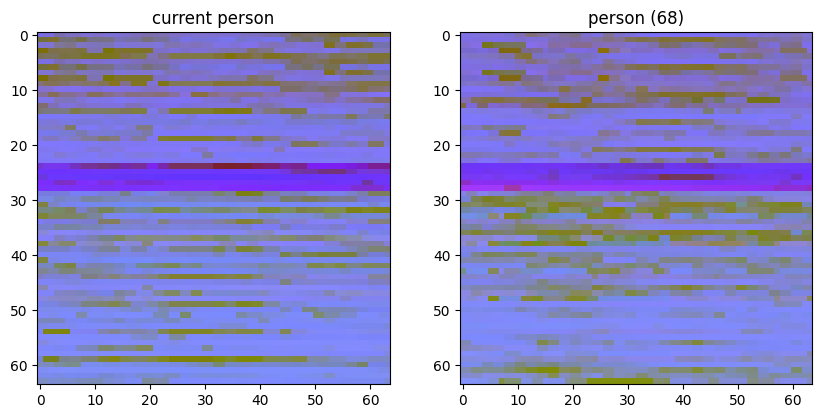

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(query_image)
axs[0].set_title('current person')

similar_img = mpimg.imread(most_similar_image_path)
axs[1].imshow(similar_img)
axs[1].set_title(most_similar_image_path.split('/')[1].split('.')[0])

plt.show()